---
title: "cross-validation"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

I'll start this chapter by summing up what we found out in the last chapter.
Our experimental data consisted of 50 data points, which we split into a training set of 30 data points and a test set of 20 data points. We fitted polynomials of degree 1 to 15 to the training data, and we evaluated their performance by computing the MSE on a different dataset, the test set. We found that the performance followed a typical U-shape, where the MSE on the test set initially decreased as we increased the degree of the polynomial, but after a certain point it started to increase again.

At the very beginning of this procedure, we randomly split the whole dataset into a training set and a test set. What would happend if we had done a different random split? We'll do exactly that now, see below.

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from numpy.polynomial import Chebyshev
blue = "xkcd:cerulean"
gold = "xkcd:gold"
pink = "xkcd:hot pink"
green = "xkcd:forest"

In [2]:
#| code-summary: "split dataset into two different training and test sets"
np.random.seed(0)
N = 10000
f = lambda x: np.sin(4*np.pi*x) + 3*x
pop_x = np.linspace(0, 1, N)
noise_pop = np.random.normal(0, 0.3, size=N)
pop_y = f(pop_x) + noise_pop

np.random.seed(0)
n = 50

idx = np.random.choice(N, size=n, replace=False)
sample_x = pop_x[idx]
sample_y = pop_y[idx]

train1_x = sample_x[:30]
train1_y = sample_y[:30]
test1_x = sample_x[30:]
test1_y = sample_y[30:]

train2_x = sample_x[-30:]
train2_y = sample_y[-30:]
test2_x = sample_x[:20]
test2_y = sample_y[:20]

In [3]:
#| code-summary: "compute MSE on training set for each dataset"
d_list = np.arange(1, 16)
MSE1_test = []; MSE2_test = []
trained_polys1 = []; trained_polys2 = []
for i, degree in enumerate(d_list):
    coeffs1 = np.polyfit(train1_x, train1_y, degree)
    coeffs2 = np.polyfit(train2_x, train2_y, degree)
    poly1 = np.poly1d(coeffs1)
    poly2 = np.poly1d(coeffs2)
    trained_polys1.append(poly1)
    trained_polys2.append(poly2)
    MSE1_test.append(np.mean((trained_polys1[i](test1_x) - test1_y)**2))
    MSE2_test.append(np.mean((trained_polys2[i](test2_x) - test2_y)**2))
MSE1_test = np.array(MSE1_test)
MSE2_test = np.array(MSE2_test)


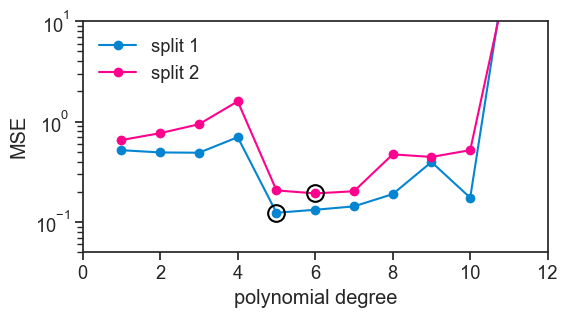

In [4]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(d_list, MSE1_test, marker='o', color=blue, label="split 1")
ax.plot(d_list, MSE2_test, marker='o', color=pink, label="split 2")
idx1 = np.argmin(MSE1_test)
idx2 = np.argmin(MSE2_test)
ax.plot(d_list[idx1], MSE1_test[idx1], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)
ax.plot(d_list[idx2], MSE2_test[idx2], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)
ax.legend(loc="upper left", frameon=False)
ax.set_yscale('log')
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       ylim=(5e-2, 1e1),
       xlim=(0,12)
       );

Clearly, the results are not the same. Had we relied on this kind of analysis to decide which polynomial degree to use, we would have come to a different conclusion. To make it clear, I put a black circle around the best performing polynomial in each curve. In the first split, the best performing polynomial was the degree 5 polynomial, while for the second split it was the degree 6 polynomial.

This is the problem that cross-validation tries to solve. We would like to minimize the sensitivity of our conclusions on the particular random split of the data.

## three different goals

It is best to make explicit three different goals that we may have when we are trying to find a good model for our data.

1. **Training:** We want to find the model parameters that best fit the data we have. In the example here, this is done by fitting polynomials of different degrees to the data. There are several names for the adjustable knobs of a model, such as parameters, coefficients, weights, etc. It's all the same.
1. **Model selection:** Among the several models that we have fitted, we want to select the one that performs best on *unseen* data. The different modeling choices are determined by **hyperparameters**, which are different from the parameters mentioned in the previous point. In our example, the hyperparameter is the degree of the polynomial. For random forests, the hyperparameters include the number of trees, the maximum depth of each tree, etc. Model selection is the problem of choosing the best hyperparameters.
1. **Model performance:** Once we have selected a model, we want to estimate how well it will perform on new data. This is the problem of estimating the generalization error of our model.

The idea of cross-validation is that we split our dataset into three parts, each of which is used to solve one of the three problems mentioned above. If we have it clear what our three goals are, it becomes much easier to understand not only how to do cross-validation, but also what not to do.

## splitting the data

### hold-out or test set

The very first thing we do is to take part of the whole dataset and set it aside. We don't touch it until the very end. The procedures after that cannot absolutely be informed by the data in this hold-out set. We will only use it at the very end to get an unbiased estimate of the generalization error of our final model.

The name "hold-out" comes from the fact that we are holding out a part of the data until the very end. The name "test set" comes from the fact that we will use this part of the data to test our final model. I like to keep in the back of my mind that they we're really talking about a "performance set", because it makes it clear that this part of the data is used to estimate the performance of our final model. Whatever isn't part of the performance set is called the training set, because we will use it to train our models.

In [5]:
np.random.seed(1)
idx_test = np.random.choice(len(sample_x), size=10, replace=False)
test_x = sample_x[idx_test]
test_y = sample_y[idx_test]
remaining_idx = np.setdiff1d(np.arange(len(sample_x)), idx_test)
train_x = sample_x[remaining_idx]
train_y = sample_y[remaining_idx]

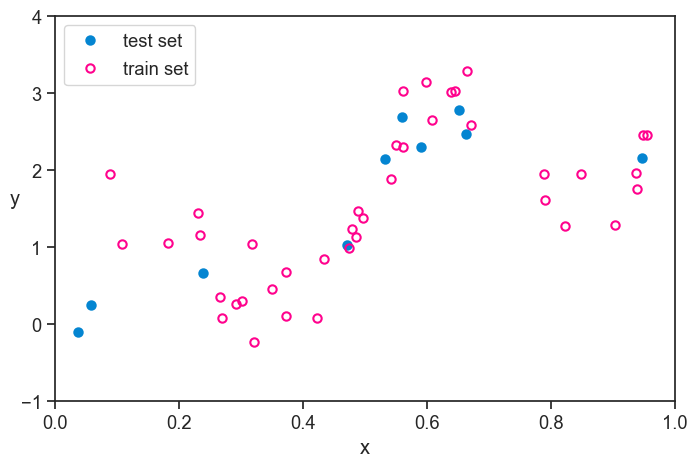

In [6]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(test_x, test_y, ls="None", marker='o', markersize=6,
        markerfacecolor=blue, markeredgecolor=blue, 
        markeredgewidth=1.5, clip_on=False, label="test set")
ax.plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor=pink, 
        markeredgewidth=1.5, clip_on=False, label="train set")
ax.legend(loc="upper left", frameon=True)
ax.set(xlabel="x",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);

### k-fold cross-validation

I will talk about a specific procedure for doing cross-validation, which is called k-fold cross-validation. The idea is that we split the data into k different parts, which we call folds. We use k-1 of the folds to train our model and the remaining fold to evaluate its performance. We repeat this procedure k times, each time using a different fold as the test set. Finally, we average the performance across the k different folds to get an estimate of the generalization error of our model. We began this chapter by showing two particular splits of the data, which are just two particular folds. By doing k-fold cross-validation, we will get k curves like the ones we showed at the beginning, not only two. Let's see how this works for 5 folds.

In [7]:
#| code-summary: "run k-fold cross-validation"
import scipy


def k_fold(x, y, degree, k=5, seed=0):
    # super important
    rng = np.random.default_rng(seed)
    n = len(x)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    mse_per_fold = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
        train_x, train_y = x[train_idx], y[train_idx]
        val_x, val_y = x[val_idx], y[val_idx]
        coeffs = np.polyfit(train_x, train_y, degree)
        poly = np.poly1d(coeffs)
        mse_per_fold.append(np.mean((poly(val_x) - val_y)**2))
    return np.array(mse_per_fold)

mse_array = np.empty((0, 5))
for d in d_list:
    mse_array = np.vstack((mse_array, k_fold(train_x, train_y, degree=d, k=5, seed=0)))
mean_mse = np.mean(mse_array, axis=1)
std_mse = np.std(mse_array, axis=1)
se_mse = scipy.stats.sem(mse_array, axis=1)

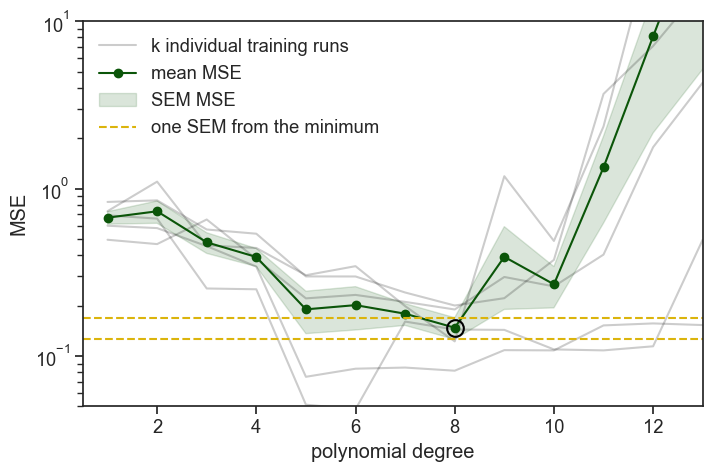

In [8]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
for j in range(5):
    ax.plot(d_list, mse_array[:,j], color="black", alpha=0.2)
ax.plot([],[], color="black", alpha=0.2, label="k individual training runs")
ax.plot(d_list, mean_mse, color=green, marker='o', label="mean MSE")
ax.fill_between(d_list, mean_mse-se_mse, mean_mse+se_mse, color=green, alpha=0.15, label="SEM MSE")
idx_min = np.argmin(mean_mse)
ax.axhline(mean_mse[idx_min]-se_mse[idx_min], color=gold, alpha=1, ls="--")
ax.axhline(mean_mse[idx_min]+se_mse[idx_min], color=gold, alpha=1, ls="--", label="one SEM from the minimum")
ax.plot(d_list[idx_min], mean_mse[idx_min], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)
ax.set_yscale('log')
ax.legend(loc="upper left", frameon=False)
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       ylim=(5e-2, 1e1),
       xlim=(0.5,13)
       );

We ran 5 times the same procedure: we fit polynomial degrees on 4/5 of the data and evaluated (computed the MSE) on the remaining 1/5. On the graph above you see all five realizations of this procedure, plus the mean and standard error of the mean of the MSE across the five folds.

That's the easy way to understand it. In reality, instead of fixing first the datasets and then fitting the models, we first fix the polynomial degree, and then we do the k-fold cross-validation. This works because we were careful to split the 5 folds using the same random seed, so every time we do the k-fold cross-validation for a given polynomial degree, we are using the same splits of the data.

## model selection
On the graph above, we added a black circle around the best performing polynomial degree, which is degree 8. Before we select it, we recognize that chance played a role in the results, and that other polynomial degrees might fall within one SEM (standard error of the mean) of the best performing degree. In this case, there are no other degrees that fall within one SEM of degree 8, so we choose it. If there were other degrees that fell within one SEM of degree 8, we would choose the one with the lowest degree among them, because it is simpler and less likely to overfit.

We chose degree 8 as our final model. Now what? We have 5 different lists of the parameters of the degree 8 polynomial, one for each fold. Which one do we choose?

None of them! We will fit a new degree 8 polynomial to the **whole training set**. This is our final model.

In [9]:
#| code-summary: "compute y hat"
yhat_n = []
for degree in d_list:
    coeffs = np.polyfit(train_x, train_y, degree)
    poly = np.poly1d(coeffs)
    yhat_n.append(poly)

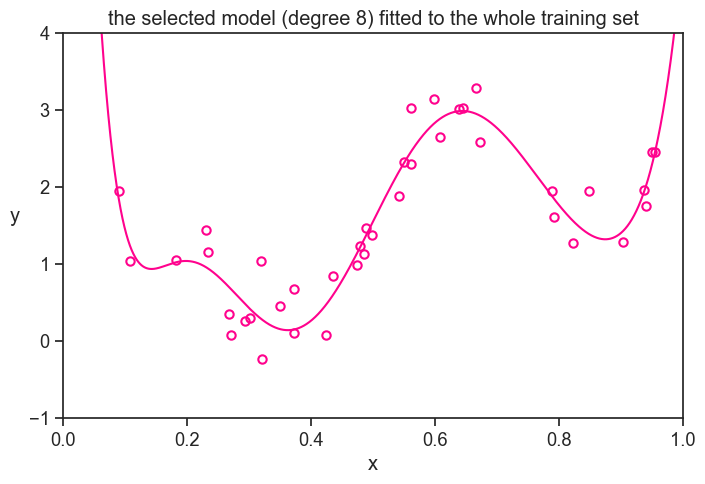

In [10]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(pop_x, (yhat_n[8-1])(pop_x),
        color=pink, label=r'true function, $f(x)$')
# ax.plot(pop_x, (yhat_n[5-1])(pop_x),
#         color=gold, label=r'true function, $f(x)$')
ax.plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor=pink, 
        markeredgewidth=1.5, clip_on=False, label="train set")
ax.set_ylabel("y", rotation=0, labelpad=10)
ax.set(xlabel="x",
       title="the selected model (degree 8) fitted to the whole training set",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4));

## performance

That's the very last step. Our choice is made, all's left is to estimate the generalization error of our final model. We do this by computing the MSE of our final model on the hold-out set, which we haven't touched until now. This gives us an unbiased estimate of the generalization error of our final model. I'll do the same for all other polynomial degrees, so we can compare them.

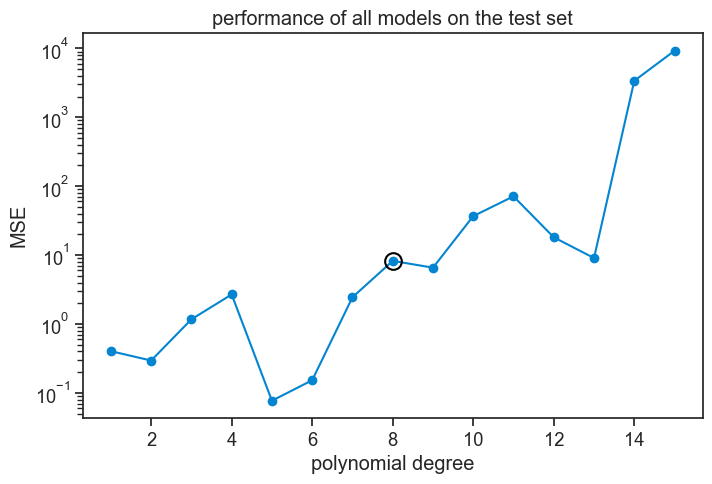

In [11]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
MSE = []
for degree in d_list:
    yhat = yhat_n[degree-1](test_x)
    MSE.append(np.mean((yhat - test_y)**2))
MSE = np.array(MSE)
ax.plot(d_list, MSE, marker='o', color=blue, label="test set")
ax.plot(d_list[7], MSE[7], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)


ax.set_yscale('log')
ax.set(title="performance of all models on the test set",
       xlabel="polynomial degree",
       ylabel="MSE",);

Oops! Is there something wrong here? We chose degree 8 because in validation it had the lowest MSE, but now that we evaluate its performance on the hold-out set, it does **worse than all other degrees smaller than itself!**

When I first saw this result I thought: "bummer, that ruins the narrative!" I thought this was a bug needed to be fixed. I then realized that I couldn't wish for a better result from an educational perspective. That's why we're here, to learn! 

The lesson to be learned is that cross-validation does not guarantee that the best performing model in model selection (validation) will also be the best performing model in  testing. It only gives us a **better chance** of selecting a good model. Randomness is still involved in the process, and we might have just been unlucky with our particular splits of the data.  k-folds cross-validation shuffles the train and validation sets, but it doesn't touch the test set, which is the one that gives us the final estimate of the generalization error. Maybe we were just unlucky?

Take the polynomial degree 5, its MSE is 100 times smaller than the MSE of degree 8 on the hold-out set. How can that be? Let's see both polynomials against the test set (left) and against the training set (right).

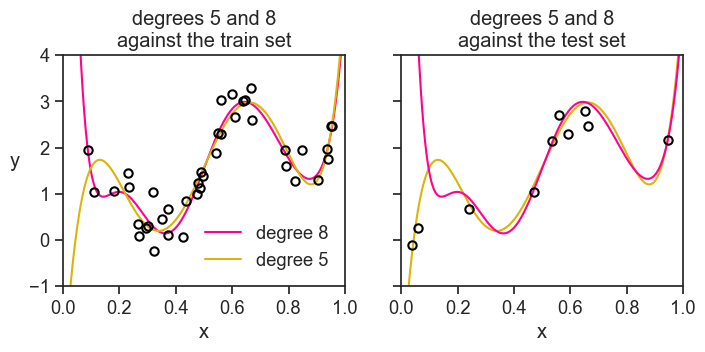

In [12]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

ax[0].plot(pop_x, (yhat_n[8-1])(pop_x),
        color=pink, label='degree 8')
ax[0].plot(pop_x, (yhat_n[5-1])(pop_x),
        color=gold, label='degree 5')
ax[0].plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor="black", 
        markeredgewidth=1.5, clip_on=False)
ax[0].legend(loc="lower right", frameon=False)
ax[1].plot(pop_x, (yhat_n[5-1])(pop_x),
        color=gold, label='degree 5')
ax[1].plot(pop_x, (yhat_n[8-1])(pop_x),
        color=pink, label='degree 8')
ax[1].plot(test_x, test_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor="black", 
        markeredgewidth=1.5, clip_on=False, label="test set")
ax[0].set_ylabel("y", rotation=0, labelpad=10)
ax[0].set(xlabel="x",
       title="degrees 5 and 8\nagainst the train set",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4))
ax[1].set(xlabel="x",
          title="degrees 5 and 8\nagainst the test set",);

Yes, we were just unlucky. All polynomial orders were incentivized during training to capture the the higher dots on the left of the train set. What happened in the performance stage? We randomly drew two dots really low on the left of the test set, something never seen during training. By pure chance the degree 5 polynomial passes next to them, while the degree 8 polynomial goes way up, incurring in a huge error.

Just to drive this point home, I'll perform all the k-fold cross-validation again. I'll use the exact same experimental dataset, but I'll make sure the first split of the data, which decides the train/test split, is different from the one we had before.

## a different hold-out set

In [13]:
#| code-summary: "different train/test split"
# this seed was 0 before, we keep it
np.random.seed(0)
n = 50

idx = np.random.choice(N, size=n, replace=False)
sample2_x = pop_x[idx]
sample2_y = pop_y[idx]

# this seed was 1 before, we change it
# to guarantee a different train/test split from the one we had before
np.random.seed(2)
idx_test = np.random.choice(len(sample2_x), size=10, replace=False)
test2_x = sample2_x[idx_test]
test2_y = sample2_y[idx_test]
remaining_idx = np.setdiff1d(np.arange(len(sample2_x)), idx_test)
train2_x = sample2_x[remaining_idx]
train2_y = sample2_y[remaining_idx]

mse_array2 = np.empty((0, 5))
for d in d_list:
    mse_array2 = np.vstack((mse_array2, k_fold(train2_x, train2_y, degree=d, k=5, seed=0))) # seed was 0 before, we can keep it...
mean_mse2 = np.mean(mse_array2, axis=1)
std_mse2 = np.std(mse_array2, axis=1)
se_mse2 = scipy.stats.sem(mse_array2, axis=1)

yhat_n2 = []
for degree in d_list:
    coeffs = np.polyfit(train2_x, train2_y, degree)
    poly = np.poly1d(coeffs)
    yhat_n2.append(poly)

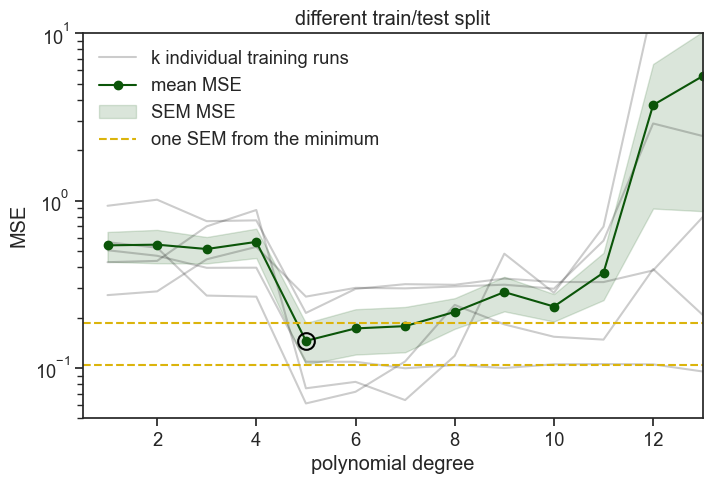

In [14]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
for j in range(5):
    ax.plot(d_list, mse_array2[:,j], color="black", alpha=0.2)
ax.plot([],[], color="black", alpha=0.2, label="k individual training runs")
ax.plot(d_list, mean_mse2, color=green, marker='o', label="mean MSE")
ax.fill_between(d_list, mean_mse2-se_mse2, mean_mse2+se_mse2, color=green, alpha=0.15, label="SEM MSE")
idx_min = np.argmin(mean_mse2)
ax.plot(d_list[idx_min], mean_mse2[idx_min], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)
idx_min = np.argmin(mean_mse2)
ax.axhline(mean_mse2[idx_min]-se_mse2[idx_min], color=gold, alpha=1, ls="--")
ax.axhline(mean_mse2[idx_min]+se_mse2[idx_min], color=gold, alpha=1, ls="--", label="one SEM from the minimum")
ax.set_yscale('log')
ax.legend(loc="upper left", frameon=False)
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       ylim=(5e-2, 1e1),
       xlim=(0.5,13),
       title="different train/test split"
       );

This time the best performing model in the validation was degree 5. Degrees 6 and 7 lie within one SEM of degree 5, so we choose the lower value, degree 5.

Now let's see the performance of all degrees on the hold-out set.

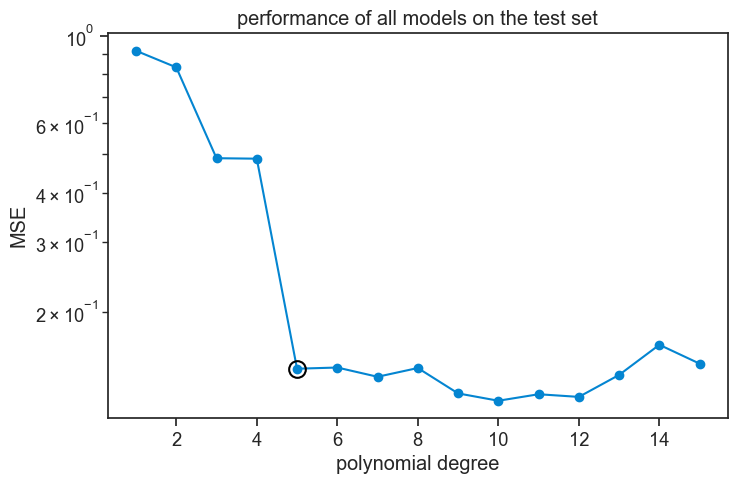

In [15]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
MSE2 = []
for degree in d_list:
    yhat = yhat_n2[degree-1](test2_x)
    MSE2.append(np.mean((yhat - test2_y)**2))
MSE2 = np.array(MSE2)
ax.plot(d_list, MSE2, marker='o', color=blue, label="test set")
ax.plot(d_list[idx_min], MSE2[idx_min], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)


ax.set_yscale('log')
ax.set(title="performance of all models on the test set",
       xlabel="polynomial degree",
       ylabel="MSE",);

Now we see that, in general terms, all polynomial orders from 5 and above perform approximately equally well.

What do I take from this? That cross-validation is a bit art and a bit science, probably more art than science. We need to know how it works to use it well, and to know what our results mean, and especially what they don't mean.

As a final simulation, we will see what happens if we perform k-fold cross-validation on a larger dataset of 250 data points, instead of 50.

## a much larger dataset

In [16]:
# this was 0 before
np.random.seed(0)
n = 250

idx = np.random.choice(N, size=n, replace=False)
sample3_x = pop_x[idx]
sample3_y = pop_y[idx]

# this was 1 before
np.random.seed(1)
idx_test = np.random.choice(len(sample3_x), size=50, replace=False)
test3_x = sample3_x[idx_test]
test3_y = sample3_y[idx_test]
remaining_idx = np.setdiff1d(np.arange(len(sample3_x)), idx_test)
train3_x = sample3_x[remaining_idx]
train3_y = sample3_y[remaining_idx]

mse_array3 = np.empty((0, 5))
for d in d_list:
    mse_array3 = np.vstack((mse_array3, k_fold(train3_x, train3_y, degree=d, k=5, seed=0))) # seed was 0 before
mean_mse3 = np.mean(mse_array3, axis=1)
std_mse3 = np.std(mse_array3, axis=1)
se_mse3 = scipy.stats.sem(mse_array3, axis=1)

yhat_n3 = []
for degree in d_list:
    coeffs = np.polyfit(train3_x, train3_y, degree)
    poly = np.poly1d(coeffs)
    yhat_n3.append(poly)

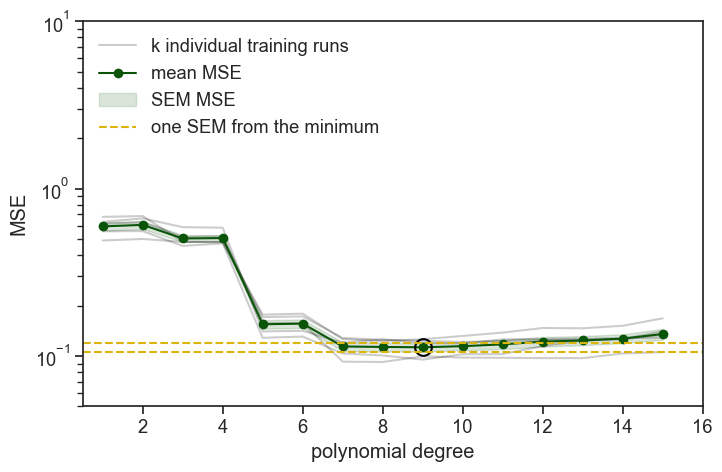

In [17]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
for j in range(5):
    ax.plot(d_list, mse_array3[:,j], color="black", alpha=0.2)
ax.plot([],[], color="black", alpha=0.2, label="k individual training runs")
ax.plot(d_list, mean_mse3, color=green, marker='o', label="mean MSE")
ax.fill_between(d_list, mean_mse3-se_mse3, mean_mse3+se_mse3, color=green, alpha=0.15, label="SEM MSE")
idx_min = np.argmin(mean_mse3)
ax.plot(d_list[idx_min], mean_mse3[idx_min], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)
ax.axhline(mean_mse3[idx_min]-se_mse3[idx_min], color=gold, alpha=1, ls="--")
ax.axhline(mean_mse3[idx_min]+se_mse3[idx_min], color=gold, alpha=1, ls="--", label="one SEM from the minimum")
ax.set_yscale('log')
ax.legend(loc="upper left", frameon=False)
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       ylim=(5e-2, 1e1),
       xlim=(0.5,16)
       );

The best performing degree is 9, but degree 7 is the lowest degree that falls within one SEM of degree 9, so we choose degree 7 as our final model.

The most important thing to notice is that all the gray lines, representing the MSE of the different folds, are much more similar to each other than in the previous simulations. See how the 1 SEM envelope is much tighter around the mean MSE. The whole idea of cross-validation was to try to neutralize the effect of randomness in the splits of the data, but for larger datasets the effect of randomness is smaller to begin with, so the effect of cross-validation is smaller as well. Cross-validation is an important tool in our toolbox, but it is most useful for smaller datasets, and should not be used in every case.

Let's see how the polynomial of degree 7 performs on the hold-out set, and compare it to the performance of the other degrees.

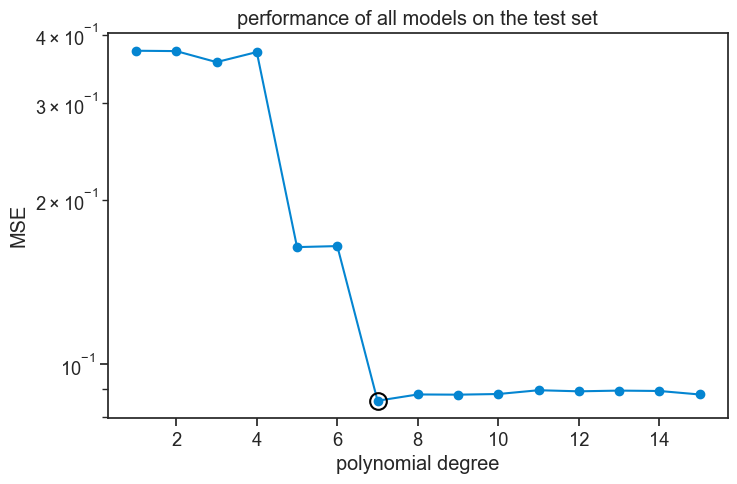

In [18]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
MSE3 = []
idx_min = 7 - 1
for degree in d_list:
    yhat = yhat_n3[degree-1](test3_x)
    MSE3.append(np.mean((yhat - test3_y)**2))
MSE3 = np.array(MSE3)
ax.plot(d_list, MSE3, marker='o', color=blue, label="test set")
ax.plot(d_list[idx_min], MSE3[idx_min], ls="None", marker='o', mfc="None", mec="black", markersize=12, markeredgewidth=1.5)


ax.set_yscale('log')
ax.set(title="performance of all models on the test set",
       xlabel="polynomial degree",
       ylabel="MSE",);

This performace graph looks much like the validation graph, which is expected for larger datasets.

## concluding remarks

When I started learning about cross-validation, the different datasets confused me, and I tended confuse which I should use and for what purpose. I'd like to offer a clear way of thinking about this. We should first think of the three different goals we have when we are trying to find a good model for our data:

1. **Training** variations of the model. In other words, finding the best set of **parameters**.
1. **Selecting** the best model. In this stage we choose the best **hyperparameters**, which are the different modeling choices we have, such as the degree of the polynomial, the number of trees in a random forest, etc.
1. Estimating the **performance** of the selected model. In this last stage we simply quantify how well the selected model performs on new data.

Each set of the data corresponds to one of these three goals. The training set is used to train the models, the validation set is used to select the best model, and the test set is used to estimate the performance of the selected model. If I were king of statistics for one day, the first thing I would do is to change the names of these datasets to make obvious what they are for. Training set is great, nothing to change there. The worst offender is the validation set. Validation usually means "to check if something is correct", but here we are not checking if something is correct, we are selecting the best model among several candidates. Test set is not bad, but I would change it to "performance set" to make it clear what it is for.

<!-- Core question

What does it mean, in practice, to fit too little or too much?

Main goal

Connect qualitative language to quantitative behavior.

Topics to cover

single train / test split

training error vs test error

polynomial degree as complexity

visual examples:

underfit curve

overfit curve

relationship to bias–variance (high level only)

how noise level affects overfitting -->

<!-- Core question

Where does prediction error come from?

Main goal

Make bias and variance visible, not operational.

Topics to cover

synthetic data from a known function

repeated datasets (or resampling)

polynomial fits of varying degree

averaging predictions at fixed x

visualization of:

mean prediction (bias)

spread of predictions (variance)

conceptual error decomposition (no heavy math) -->